# E-18 프로젝트: 뉴스기사 요약해보기

In [5]:
import urllib.request
import pandas as pd
import numpy as np

import nltk
nltk.download('stopwords')

import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/aiffel0042/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 데이터 수집하기

In [2]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [3]:
data.sample(10)

,headlines,text
53397,Firefox browser releases fix for flaws in micr...,Open-source software community Mozilla has rel...
46980,Baroda drop Yusuf Pathan 4 months after oustin...,Yusuf Pathan has been dropped from the Baroda ...
35229,Nadal takes a dig at Federer for missing clay ...,World number one Rafael Nadal teased world num...
94179,Trump aide drew plan on napkin to partition Li...,US President Donald Trump's Deputy Assistant S...
64367,I knew my biography would upset a lot of peopl...,"Nawazuddin Siddiqui, while speaking about his ..."
71005,Royal Bhutan plane catches fire at Kolkata air...,A Bangkok-bound Royal Bhutan plane caught fire...
49994,"Crypto firm cheats investors, website reads 'p...","Cryptocurrency startup Prodeum, which aimed to..."
59679,EPS-OPS faction wins back AIADMK's two-leaves ...,The Election Commission has restored the 'two ...
68928,China organises blind dates to get single peop...,The Chinese government has launched a blind da...
90231,France bans 'extremely thin' fashion models,A law banning excessively thin models has come...


이 데이터는 기사의 본문에 해당되는 text와 headlines 두 가지 열로 구성되어져 있습니다.

추상적 요약을 하는 경우에는 text를 본문, headlines를 이미 요약된 데이터로 삼아서 모델을 학습할 수 있어요. 추출적 요약을 하는 경우에는 오직 text열만을 사용.

## 데이터 전처리하기 (추상적 요약)

실습에서 사용된 전처리를 참고하여 각자 필요하다고 생각하는 전처리를 추가 사용하여 텍스트를 정규화 또는 정제해 보세요. 만약, 불용어 제거를 선택한다면 상대적으로 길이가 짧은 요약 데이터에 대해서도 불용어를 제거하는 것이 좋을지 고민해보세요.

### 중복 샘플 및 NULL 값 존재하는 샘플 제거

In [7]:
# 원래 data len
len(data)

98401

In [6]:
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


서로 다른 텍스트 대해 중복되는 제목이 존재할 수 있다. 따라서, 중복되는 텍스트만 제거

In [8]:
data.drop_duplicates(subset = ['text'], inplace = True)
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 98360


null 값을 갖는 샘플 확인.

In [9]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


null 값을 갖는 샘플이 없다.

In [11]:
# data.dropna(axis = 0, inplace = True)
# print('전체 샘플수:',(len(data)))

### 텍스트 정규화와 불용어 제거

In [12]:
# 출처 : [https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python](https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python)
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ",len(contractions))

정규화 사전의 수:  120


불용어 제거

In [13]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

데이터 전처리 함수   
- 모든 영어문자 소문자로
- 섞여있는 html 태그 제거
- 정규 표현식을 통해 특수문자, 숫자 제거
- text는 불용어 제거, headlines는 불용어 제거하지 않음. headlines는 그 자체로 압축된 텍스트이기때문.

In [15]:
#데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","",sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (headlines)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [16]:
clean_text = []

# 전체 text 데이터에 대한 전처리 
for s in data['text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
clean_text[:5]

['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers',
 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit',
 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history',
 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insure critical il

In [17]:
clean_summary = []

# 전체 headlines 데이터에 대한 전처리 
for s in data['headlines']:
    clean_summary.append(preprocess_sentence(s, False))

clean_summary[:5]

['upgrad learner switches to career in ml al with salary hike',
 'delhi techie wins free food from swiggy for one year on cred',
 'new zealand end rohit sharma led india match winning streak',
 'aegon life iterm insurance plan helps customers save tax',
 'have known hirani for yrs what if metoo claims are not true sonam']

정제 이후, 다시 한 번 빈 샘플이 생겼는지 확인할 필요가 있음!

In [18]:
data['text'] = clean_text
data['headlines'] = clean_summary

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

null 값 확인

In [19]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

null 값 없다.

In [22]:
# data.dropna(axis=0, inplace=True)
# print('전체 샘플수 :',(len(data)))#데이터 전처리 함수

### 훈련 데이터와 테스트 데이터 나누기

샘플 최대 길이 정하기

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


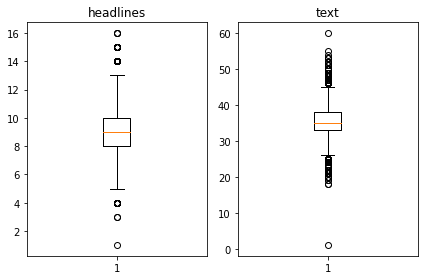

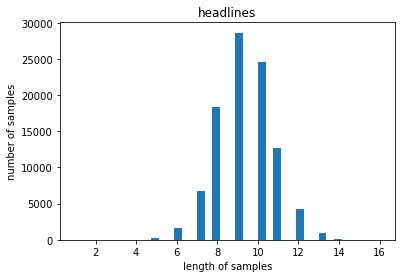

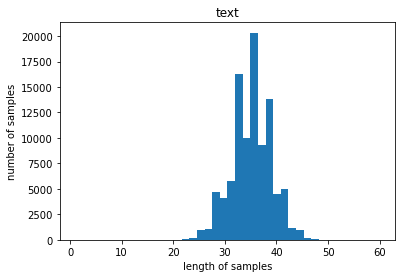

In [23]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
summary_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(summary_len)
plt.title('headlines')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('text')
plt.tight_layout()
plt.show()

plt.title('headlines')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [64]:
# 임의로 max_len 정하기
text_max_len = 38
summary_max_len = 11

In [65]:
# 임의로 max_len 정했을 때 얼마나 많은 샘플을 자르지 않고 포함할 수 있는가?
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [66]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(summary_max_len,  data['headlines'])

전체 샘플 중 길이가 38 이하인 샘플의 비율: 1.0
전체 샘플 중 길이가 11 이하인 샘플의 비율: 1.0


노드에서 사용한 데이터에 대해 적용한 최대 길이에서 산출되는 비율과 최대한 비슷한 
text의 최대 길이는 38, headline 의 최대 길이는 11로 놓고 진행한다.

상기 결과는 데이터를 변형시킨 후에 다시 한 번 함수를 실행하여 100% 로 나오게 된 것임.   
원래 분포는 약 81%, 94% 정도였음.

In [67]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= summary_max_len)]
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 75754


시작 토큰과 종료 토큰 추가

In [68]:
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
7,govt directs alok verma to join work day befor...,weeks ex cbi director alok verma told departme...,sostoken govt directs alok verma to join work ...,govt directs alok verma to join work day befor...
8,called pm modi sir times to satisfy his ego an...,andhra pradesh cm chandrababu naidu said met u...,sostoken called pm modi sir times to satisfy h...,called pm modi sir times to satisfy his ego an...


In [69]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

데이터 분리   
sklearn 에서 제공하는 모듈 등을 사용해도 되겠지만, 노드에서 진행한 것처럼 직접 해본다.

In [70]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[46267 38601 39965 ... 42342 41834 54999]


In [71]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [72]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :',n_of_val)

테스트 데이터의 수 : 15150


In [73]:
# n_of_val = int(len(encoder_input)*0.8) 로 놓고,
# encoder_input_train = encoder_input[:n_of_val]
# encoder_input_test = encoder_input[n_of_val:]
# 이렇게 하는거랑 같음.

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

훈련 데이터의 개수 : 60604
훈련 레이블의 개수 : 60604
테스트 데이터의 개수 : 15150
테스트 레이블의 개수 : 15150


### 정수 인코딩

In [74]:
# 단어집합 만들기
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [80]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 60320
등장 빈도가 6번 이하인 희귀 단어의 수: 41272
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 19048
단어 집합에서 희귀 단어의 비율: 68.42175066312997
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.091182318398298


encoder input에서 등장 빈도가 7회 미만인 희귀 단어가 단어 집합에서 차지하는 비중이 68%정도, 전체 데이터에서 희귀 데이터가 등장하는 빈도는 약 4% 밖에 되지 않음.

In [81]:
# 19048 을 어림잡아 19000
src_vocab = 19000
src_tokenizer = Tokenizer(num_words = src_vocab) # 단어 집합의 크기 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성.

In [82]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

#잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

# Summary 데이터에 대해서도 적용.
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

[[823, 57, 3567, 10, 3190, 137, 6702, 824, 2509, 31, 45, 824, 908, 812, 7604, 323, 6226, 447, 2679, 672, 2199, 169, 11579, 7604, 6, 7449, 3604, 1985, 3692, 575], [32, 2471, 1970, 3746, 5973, 5271, 37, 229, 169, 1410, 398, 81, 1788, 720, 3747, 8790, 3568, 2471, 1970, 5973, 6, 37, 326, 3747, 169, 662, 9641, 5974, 2, 2490, 2148, 2471, 1970, 2890, 2149, 747, 492], [1828, 57, 51, 15, 4806, 383, 2932, 66, 40, 497, 2813, 2037, 981, 111, 1305, 635, 2148, 939, 1005, 2813, 2354, 16665, 4901, 7724, 12019, 162, 4213, 60, 4700, 11188, 570, 2037, 94, 981]]


In [90]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 27066
등장 빈도가 5번 이하인 희귀 단어의 수: 18025
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 9041
단어 집합에서 희귀 단어의 비율: 66.59646789329786
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.617810942031347


decoder input에서 등장빈도 5회 이하 단어들이 단어 집합에서 약 67%를 차지, 하지만 전체 데이터에서 차지하는 비율은 약 6%

In [91]:
# 9041을 어림잡아 9000
tar_vocab = 9000
tar_tokenizer = Tokenizer(num_words = tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

#잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 317, 393, 2395, 79, 45, 2291, 103, 3872, 1133], [1, 495, 178, 3, 1688, 2139, 176, 1097, 687, 159, 5774, 3873], [1, 819, 38, 144, 34, 412, 3, 12, 1658, 41, 1359], [1, 133, 1424, 81, 12, 7020, 508, 4346, 3, 2013], [1, 902, 941, 872, 14, 58, 4, 4020, 6, 6115]]
target
decoder  [[317, 393, 2395, 79, 45, 2291, 103, 3872, 1133, 2], [495, 178, 3, 1688, 2139, 176, 1097, 687, 159, 5774, 3873, 2], [819, 38, 144, 34, 412, 3, 12, 1658, 41, 1359, 2], [133, 1424, 81, 12, 7020, 508, 4346, 3, 2013, 2], [902, 941, 872, 14, 58, 4, 4020, 6, 6115, 2]]


길이가 비교적 긴 text는 문제가 없겠지만, headlines의 경우, 빈도수가 낮은 단어만으로 구성된 샘플은 빈 샘플이 되었을 가능성이 있음.
단, decoder_input에는 시작, 끝 토큰이 추가된 상태 => 빈 샘플이어도 실제 길이는 1   

text는 문제가 없겠다고 언급하기는 했지만, 혹시 모르니 확인은 한 번 해본다.

In [94]:
drop_endocer_train = [index for index, sentence in enumerate(encoder_input_train) if len(sentence) == 0]
drop_endocer_test = [index for index, sentence in enumerate(encoder_input_test) if len(sentence) == 0]

print('삭제할 ecoder 훈련 데이터의 개수 :',len(drop_endocer_train))
print('삭제할 encoder 테스트 데이터의 개수 :',len(drop_endocer_test))

삭제할 ecoder 훈련 데이터의 개수 : 0
삭제할 encoder 테스트 데이터의 개수 : 0


In [95]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 decoder 훈련 데이터의 개수 :',len(drop_train))
print('삭제할 decoder 테스트 데이터의 개수 :',len(drop_test))

encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

삭제할 decoder 훈련 데이터의 개수 : 1
삭제할 decoder 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 60603
훈련 레이블의 개수 : 60603
테스트 데이터의 개수 : 15150
테스트 레이블의 개수 : 15150


패딩하기. post 패딩. 이게 더 낫다고 예전에 배웠음

In [96]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen = text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen = text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen = summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen = summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen = summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen = summary_max_len, padding='post')

## 어텐션 메커니즘 사용하기(추상적 요약)

일반적인 seq2seq보다는 어텐션 메커니즘을 사용한 seq2seq를 사용하는 것이 더 나은 성능을 얻을 수 있어요. 실습 내용을 참고하여 어텐션 메커니즘을 사용한 seq2seq를 설계해 보세요.

### 모델 설계 시작 (일단 기본 seq2seq)

In [97]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [98]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences = True, return_state = True, dropout = 0.4, recurrent_dropout=0.2)
# state_h, state_c 는 인코더에서 나온 hidden state와 cell state를 의미한다.
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = [state_h, state_c])

In [99]:
# 디코더의 출력층
# tar_vocab : 단어 집합 갯수 9000개로 제한 걸었잖아 위에서.
decoder_softmax_layer = Dense(tar_vocab, activation = 'softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 38)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 38, 128)      2432000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 38, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

### 어텐션 메커니즘 적용

In [100]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

In [101]:
# 디코더 출력층 수정

# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis = -1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 38)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 38, 128)      2432000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 38, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

## 모델 훈련

In [102]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 2)
history = model.fit(x = [encoder_input_train, decoder_input_train], y = decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size = 256, callbacks=[es], epochs = 50)

Epoch 1/50
237/237 [==============================] - 76s 322ms/step - loss: 5.9884 - val_loss: 5.5934
Epoch 2/50
237/237 [==============================] - 74s 313ms/step - loss: 5.4605 - val_loss: 5.2496
Epoch 3/50
237/237 [==============================] - 75s 318ms/step - loss: 5.1303 - val_loss: 4.9341
Epoch 4/50
237/237 [==============================] - 65s 273ms/step - loss: 4.8451 - val_loss: 4.7471
Epoch 5/50
237/237 [==============================] - 65s 273ms/step - loss: 4.6164 - val_loss: 4.5722
Epoch 6/50
237/237 [==============================] - 65s 273ms/step - loss: 4.4319 - val_loss: 4.4631
Epoch 7/50
237/237 [==============================] - 65s 274ms/step - loss: 4.2748 - val_loss: 4.3710
Epoch 8/50
237/237 [==============================] - 72s 303ms/step - loss: 4.1328 - val_loss: 4.2929
Epoch 9/50
237/237 [==============================] - 75s 315ms/step - loss: 4.0051 - val_loss: 4.2142
Epoch 10/50
237/237 [==============================] - 65s 273ms/step - l

시각화 (training loss, val loss)

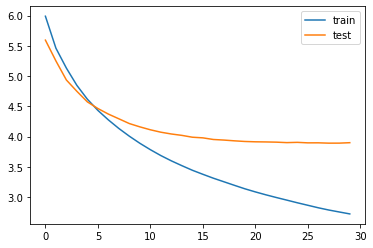

In [103]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## 인퍼런스 모델 구현

In [104]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

### 우선, 인코더 설계

In [105]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

# 디코더 임베딩 레이어2
dec_emb2 = dec_emb_layer(decoder_inputs)
# 문장의 다음 단어를 예측하기 위해서 ***초기 상태(initial_state)를 이전 시점의 상태로 사용***
# 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
# 훈련 과정에서는 _ 로 버렸었음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

### 어텐션 메커니즘을 사용하는 출력층

In [107]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
# inf : inference
# 현재 스텝에서 들어오는 input과 현재 스텝에서 내는 output 을 대상으로 attention 매커니즘 적용
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
# attention 매커니즘의 결과와 현재 스텝에서 내는 output을 합친다.
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
# 위에서 attention 매커니즘의 결과와 현재 스텝에서 내는 output을 합친 결과를 토대로 최종 추론값을 내놓는다.
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    # state_input_h, state_input_c 는 이전 state의 값들을 참조하기 위함임.
    # decoder_inputs 는 디코더에 맨 처음에 들어오는 input을 의미하는거겠지?
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

### 인퍼런스 단계에서 단어 시퀀스를 완성하는 함수

In [108]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
     # 시작 토큰을 지정해주는거임 ㅇㅇ 처음에는 target_seq를 시작 토큰으로 놓고 시작.
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    # 인퍼런스 단계는 하나의 time step 을 넘어가는 과정을 반복적으로 돌려야 하기 때문
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        # 마지막으로 뽑힌 토큰과 인코더에서 나온 값들을 토대로 predict 한다.
        # 단, 위에 어탠션 메커니즘을 정의한 내용이 적용되는거겠지.
        # 인코더에서 각 time step 마다 내놓은 결과와 state를 참조하는거임 ㅇㅇ
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        # eostoken에 도달하지 않았으면, 추출된 토큰을 문장 결과값 string에 이어붙인다.
        if(sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        # 현재 마지막으로 뽑힌 token을 지정해주는것.
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

## 실제 결과와 요약문 비교하기(추상적 요약) _ 모델 테스트

원래의 요약문(headlines 열)과 학습을 통해 얻은 추상적 요약의 결과를 비교해보세요.

In [109]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
# padding에 해당하는 0 제외
        if(i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
# padding에 해당하는 0, 시작 토큰 인덱스, 종료 토큰 인덱스 출력에서 제외.
        if((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [110]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : mumbai taj mahal palace hotel recreated celebratory indo french dinner served eve independence august executive chef amit chowdhury recreated menu help served kitchen years ago menu variations also served properties kolkata hyderabad london chennai 
실제 요약 : mumbai taj mahal hotel independence eve dinner 
예측 요약 :  kolkata cm yogi singh named as india


원문 : ibm monday unveiled artificial intelligence system called project debate humans real time ai debate topics four minute opening statement two minute closing statement development six years internal newspapers journals sources draw arguments 
실제 요약 : ibm unveils ai that can debate with humans in real time 
예측 요약 :  ibm unveils ai that can be used for mars


원문 : discussing use abusive words film kareena kapoor khan said saif ali khan villain bad lot awards film talking upcoming film veere di wedding kareena added film requires lines words words used forcefully 
실제 요약 : saif used words in and won awards kareena 
예측 요약 :  kareena an

## Summa를 이용하여 추출적 요약해보기

추상적 요약은 추출적 요약과는 달리 문장의 표현력을 다양하게 가져갈 수 있지만, 추출적 요약에 비해서 난이도가 높아요.   
반대로 말하면 추출적 요약은 추상적 요약에 비해 난이도가 낮고 기존 문장에서 문장을 꺼내오는 것이므로 잘못된 요약이 나올 가능성이 낮아요.

Summa의 summarize를 사용하여 추출적 요약을 해보세요.

In [132]:
import requests
from summa.summarizer import summarize

In [133]:
seq2text(decoder_input_test[0])

'said year numbers mehul odi year hrithik wrote '

In [135]:
summarize(seq2text(decoder_input_test[0]),words=10)

''

In [137]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", summarize(seq2text(decoder_input_test[i]),words=10))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

# # list 로 출력 받아보기
# print('Summary:')
# print(summarize(text, ratio=0.005, split=True))

# # ratio 대신 문자 수로 제한도 가능
# print('Summary:')
# print(summarize(text, words=50))

원문 : mumbai taj mahal palace hotel recreated celebratory indo french dinner served eve independence august executive chef amit chowdhury recreated menu help served kitchen years ago menu variations also served properties kolkata hyderabad london chennai 
실제 요약 : 
예측 요약 :  kolkata cm yogi singh named as india


원문 : ibm monday unveiled artificial intelligence system called project debate humans real time ai debate topics four minute opening statement two minute closing statement development six years internal newspapers journals sources draw arguments 
실제 요약 : 
예측 요약 :  ibm unveils ai that can be used for mars


원문 : discussing use abusive words film kareena kapoor khan said saif ali khan villain bad lot awards film talking upcoming film veere di wedding kareena added film requires lines words words used forcefully 
실제 요약 : 
예측 요약 :  kareena and are the best kareena on kareena debut


원문 : church sweden fired priest placing ad dating website wherein said looking relationship sex dates n

### 결과가 안 나온다!
내 생각엔, 원문 텍스트의 길이가 너무 짧아서 그런 것으로 생각된다.   
개인적으로 좋아하는 영화인 대부의 대본으로 시도하겠다.

In [141]:
text = requests.get('https://www.awesomefilm.com/script/THEGODFATHER.txt').text

In [145]:
len(text)

197393

In [144]:
# 원문의 0.005% 만을 출력해보자.
print('Summary:')
print(summarize(text, ratio=0.005))

# # list 로 출력 받아보기
# print('Summary:')
# print(summarize(text, ratio=0.005, split=True))

# # ratio 대신 문자 수로 제한도 가능
# print('Summary:')
# print(summarize(text, words=50))

Summary:
Where's Michael?
MICHAEL
MICHAEL
MICHAEL
MICHAEL
MICHAEL
MICHAEL
MICHAEL
MICHAEL
MICHAEL
MICHAEL
Michael...
MICHAEL
MICHAEL
MICHAEL
MICHAEL
MICHAEL
MICHAEL
MICHAEL
MICHAEL
MICHAEL
MICHAEL
MICHAEL
And Michael?
driver's seat: the DON enters the car, looks at MICHAEL, who
MICHAEL
MICHAEL
MICHAEL
The FIRST MAN opens the car door, and MICHAEL steps out.
SONNY, MICHAEL, HAGEN, CLEMENZA and TESSIO; all exhausted,
MICHAEL looks at the OLD MAN, his eyes are open, though he
Inside the car: MICHAEL, FREDO, TOM HAGEN and a new man,


마이클을 참 많이 부르긴 한다.

# 결과 보고서

### 소감
어디선가 얼핏 들었던 어탠션 매커니즘의 아이디어를 간단하게나마 구현해볼 수 있어서 의미있었다.   
seq2seq 모델의 인퍼런스 모델을 따로 구현하는 과정에서, 코드를 이해하는 것에 꽤 애를 먹었다. 사실 지금도 완전히 이해했다고는 생각이 들지는 않고, 일단 덕지덕지 주석을 달아놓은 상태이니, 다시 공부해야겠다.   
추론적 요약은 참 어렵다.

### 결과

***성공적 사례***
- 원문 : cab hailing startup uber us based rival lyft wednesday raised additional million series financing round led fidelity management research company taking valuation billion startup value doubled past months founded lyft raised billion since inception   
- 실제 요약 : uber rival lyft raises million at billion valuation 
- 예측 요약 :  uber rival lyft raises mn funding at bn valuation

***실패 사레가 더 많아보임***
성공적 사례도 분명 존재한다! 하지만, 대부분 실제 요약(headline)과는 조금 의미가 다른 내용들이 많았다. 그리고 동일 단어가 반복적으로 이어지며 문법적으로 어긋난 문장을 만들어내는 등의 양상을 보이는 경우가 많았다.

- 원문 : isis released image threatening launch terror attacks fifa world cup russia image shows rifle carrying isis fighter along bomb front football stadium also includes tournament official logo tournament played across cities russia june july 
- 실제 요약 : isis threatens attack during fifa world cup in russia 
- 예측 요약 :  isis attack on trump wc final final   

=> 갑자기 여기서 트럼프가 왜나오나!